In [ ]:
import torch

Open the dataset, and extract the ligand positions and protein positions


In [ ]:
compound = torch.load("/fs/pool/pool-marsot/pdbbind/pdbbind2020/dataset/processed/compound.pt")

In [ ]:
protein = torch.load("/fs/pool/pool-marsot/pdbbind/pdbbind2020/dataset/processed/protein.pt")

In [ ]:
for tens in compound["3zzf"]:
    print(tens.shape)

In [ ]:
for tens in protein["3zzf"]:
    print(tens.shape)

generate a dictionary of protein-ligand coordinates

In [3]:
import os
import torch
if not os.path.exists("/fs/pool/pool-marsot/pdbbind/pdbbind2020/dataset/processed/all_dict_coords.pt"):
    all_dict_coords = {}
    for key in compound.keys():
        dict_coords = {}
        dict_coords["compound"] = torch.tensor(compound[key][0])
        dict_coords["protein"] = protein[key][0].to(dtype=torch.float64)
        all_dict_coords[key] = dict_coords
    torch.save(all_dict_coords, "/fs/pool/pool-marsot/pdbbind/pdbbind2020/dataset/processed/all_dict_coords.pt")
else:
    all_dict_coords = torch.load("/fs/pool/pool-marsot/pdbbind/pdbbind2020/dataset/processed/all_dict_coords.pt")

Implementing MDS with noised pairwise distance coordinates

In [ ]:
complex_name = "3zzf"
ligand_coords = all_dict_coords[complex_name]["compound"]
protein_coords = all_dict_coords[complex_name]["protein"]
true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * 0
# Using a mask for the distances lower than 10
distances_lower_than_10 = torch.where(true_pairwise_distances < 10, torch.ones_like(true_pairwise_distances), torch.zeros_like(true_pairwise_distances))

In [ ]:
N = 2
M = 3
torch.arange((N+M)**2).reshape(N+M, N+M)

In [ ]:
torch.arange((N+M)**2).reshape(N+M, N+M)[N:, :N]

In [ ]:
complex_name = "3zzf"
ligand_coords = all_dict_coords[complex_name]["compound"]
protein_coords = all_dict_coords[complex_name]["protein"]
true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * 0 
# Using a mask for the distances lower than 10
distances_lower_than_10 = torch.where(true_pairwise_distances < 10, torch.ones_like(true_pairwise_distances), torch.zeros_like(true_pairwise_distances))
n = protein_coords.shape[0]
m = ligand_coords.shape[0]
V = torch.zeros(n+m, n+m, dtype=torch.float64)
V[n:, :n] = -distances_lower_than_10.T
V[:n, n:] = -distances_lower_than_10
initial_x = torch.zeros(n+m, 3, dtype=torch.float64)
initial_x[:n] = protein_coords
initial_x[n:] = torch.randn_like(ligand_coords)
V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)
diag_prot = torch.diag(torch.sum(distances_lower_than_10, dim=1))
diag_lig = torch.diag(torch.sum(distances_lower_than_10, dim=0))
initial_x = torch.zeros(n+m, 3, dtype=torch.float64)
initial_x[:n] = protein_coords
initial_x[n:] = torch.randn_like(ligand_coords)
ratio_up = torch.zeros(n+m, n+m, dtype=torch.float64)
ratio_down = torch.zeros(n+m, n+m, dtype=torch.float64)

distances_lower_than_10.shape
weights = torch.zeros(n+m, n+m, dtype=torch.float64)
weights[n:, :n] = distances_lower_than_10.T
weights[:n, n:] = distances_lower_than_10
V_3_plus = torch.linalg.pinv(V[n:, n:].to(torch.float64))
V_2 = V[n:, :n].to(torch.float64)
ratio_up[:n, n:] = noised_pairwise_distances
ratio_up[n:, :n] = noised_pairwise_distances.T

for _ in range(100):
    computed_pairwise_distances = torch.cdist(protein_coords, initial_x[n:])
    ratio_down[:n, n:] = computed_pairwise_distances
    ratio_down[n:, :n] = computed_pairwise_distances.T
    ratio = torch.nan_to_num(ratio_up/ratio_down, nan=0.0).to(dtype=torch.float64)
    B = (-ratio*weights)
    B[range(len(B)), range(len(B))] = -torch.sum(B, dim=1)

    B_2_T = B[n:, :n]
    B_3 = B[n:, n:]
    z_1 = initial_x[:n]
    z_2 = initial_x[n:]
    x = initial_x[:n]
    y = initial_x[n:]
    initial_x[n:] = V_3_plus@(B_2_T@initial_x[:n])
    print(torch.norm(initial_x[n:] - ligand_coords))

In [ ]:
computed_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
ratio_down[:n, n:] = computed_pairwise_distances
ratio_down[n:, :n] = computed_pairwise_distances.T
ratio = torch.nan_to_num(ratio_up/ratio_down, nan=0.0).to(dtype=torch.float64)
B = (-ratio*weights)
B[range(len(B)), range(len(B))] = -torch.sum(B, dim=1)

In [ ]:
torch.where(B!=V)

In [ ]:
B[41, 41], V[41,41]

In [ ]:
V = torch.zeros(n+m, n+m, dtype=torch.float64)
V[n:, :n] = -distances_lower_than_10.T
V[:n, n:] = -distances_lower_than_10
V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)

In [ ]:
V.diagonal()

In [ ]:
V.diagonal()

In [ ]:
torch.where(B!=V)

In [ ]:
weights.sum()

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming your previous code is already executed and initial_x is initialized

def plot_2d_projection(initial_x, n, iteration):
    plt.figure(figsize=(10, 6))
    # Extracting coordinates
    x_coords = initial_x[:, 0].numpy()
    y_coords = initial_x[:, 1].numpy()

    # Plotting points before n in blue
    plt.scatter(x_coords[:n], y_coords[:n], c='blue', label='Protein Coords')
    # Plotting points after n in red
    plt.scatter(x_coords[n:], y_coords[n:], c='red', label='Ligand Coords')

    # Adding title and legend
    plt.title(f'2D Projection at Iteration {iteration}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * 1

initial_x[n:] = ligand_coords
# Running the iterations and plotting
V = torch.zeros(n+m, n+m, dtype=torch.float64)
V[n:, :n] = -distances_lower_than_10.T
V[:n, n:] = -distances_lower_than_10
V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)
initial_x = torch.zeros(n+m, 3, dtype=torch.float64)
initial_x[:n] = protein_coords
initial_x[n:] = torch.randn_like(ligand_coords)

ratio_up = torch.zeros(n+m, n+m, dtype=torch.float64)
ratio_down = torch.zeros(n+m, n+m, dtype=torch.float64)
weights = torch.zeros(n+m, n+m, dtype=torch.float64)
weights[n:, :n] = distances_lower_than_10.T
weights[:n, n:] = distances_lower_than_10
V_3_plus = torch.linalg.pinv(V[n:, n:].to(torch.float64))
V_2 = V[n:, :n].to(torch.float64)
ratio_up[:n, n:] = noised_pairwise_distances
ratio_up[n:, :n] = noised_pairwise_distances.T

for iteration in range(100):
    computed_pairwise_distances = torch.cdist(protein_coords, initial_x[n:])
    ratio_down[:n, n:] = computed_pairwise_distances
    ratio_down[n:, :n] = computed_pairwise_distances.T
    ratio = torch.nan_to_num(ratio_up / ratio_down, nan=0.0).to(dtype=torch.float64)
    B = (-ratio * weights)
    B[range(len(B)), range(len(B))] = -torch.sum(B, dim=1)

    B_2_T = B[n:, :n]
    V_2_T = V[n:, :n]
    B_3 = B[n:, n:]
    x = initial_x[:n]
    y = initial_x[n:]
    initial_x[n:] = V_3_plus @ (B_2_T @ x + B_3@y - V_2_T@x)
    
    # Print the norm difference as in your code
    print(torch.norm(initial_x[n:] - ligand_coords))
    
    # Plot the 2D projection
    #plot_2d_projection(initial_x, n, iteration)


In [ ]:
complex_name = "3zzf"
ligand_coords = all_dict_coords[complex_name]["compound"]
protein_coords = all_dict_coords[complex_name]["protein"]
true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * 0 
# Using a mask for the distances lower than 10
# distances_lower_than_10 = torch.where(true_pairwise_distances < 10, torch.ones_like(true_pairwise_distances), torch.zeros_like(true_pairwise_distances))
n = protein_coords.shape[0]
m = ligand_coords.shape[0]
V = torch.zeros(n+m, n+m, dtype=torch.float64)
V[n:, :n] = -torch.ones(m, n)
V[:n, n:] = -torch.ones(n, m)
diag_prot = torch.diag(torch.sum(distances_lower_than_10, dim=1))
diag_lig = torch.diag(torch.sum(distances_lower_than_10, dim=0))
V[n:, n:] = diag_lig
V[:n, :n] = diag_prot
initial_x = torch.zeros(n+m, 3, dtype=torch.float64)
initial_x[:n] = protein_coords
initial_x[n:] = torch.randn_like(ligand_coords)
V[range(len(V)), range(len(V))] = torch.sum(V, dim=1)
ratio_up = torch.zeros(n+m, n+m, dtype=torch.float64)
ratio_down = torch.zeros(n+m, n+m, dtype=torch.float64)

distances_lower_than_10.shape
weights = torch.zeros(n+m, n+m, dtype=torch.float64)
weights[n:, :n] = distances_lower_than_10.T
weights[:n, n:] = distances_lower_than_10
V_3_plus = torch.linalg.pinv(V[n:, n:].to(torch.float64))
V_2 = V[n:, :n].to(torch.float64)
ratio_up[:n, n:] = noised_pairwise_distances
ratio_up[n:, :n] = noised_pairwise_distances.T

for _ in range(100):
    computed_pairwise_distances = torch.cdist(protein_coords, initial_x[n:])
    ratio_down[:n, n:] = computed_pairwise_distances
    ratio_down[n:, :n] = computed_pairwise_distances.T
    ratio = torch.nan_to_num(ratio_up/ratio_down, nan=0.0).to(dtype=torch.float64)
    B = (-ratio*weights)
    B[range(len(B)), range(len(B))] = -torch.sum(B, dim=1)

    B_2_T = B[n:, :n]
    B_3 = B[n:, n:]
    z_1 = initial_x[:n]
    z_2 = initial_x[n:]
    x = initial_x[:n]
    y = initial_x[n:]
    initial_x[n:] = V_3_plus@(B_2_T@initial_x[:n])
    print(torch.norm(initial_x[n:] - ligand_coords))

Version with ligand structure penalty

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming your previous code is already executed and initial_x is initialized
s = 100


def plot_2d_projection(initial_x, n, iteration):
    plt.figure(figsize=(10, 6))
    # Extracting coordinates
    x_coords = initial_x[:, 0].numpy()
    y_coords = initial_x[:, 1].numpy()

    # Plotting points before n in blue
    plt.scatter(x_coords[:n], y_coords[:n], c='blue', label='Protein Coords')
    # Plotting points after n in red
    plt.scatter(x_coords[n:], y_coords[n:], c='red', label='Ligand Coords')

    # Adding title and legend
    plt.title(f'2D Projection at Iteration {iteration}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * 1
pairwise_distances_lig = torch.cdist(ligand_coords, ligand_coords)


initial_x[n:] = ligand_coords
# Running the iterations and plotting
V = torch.zeros(n+m, n+m, dtype=torch.float64)
V[n:, :n] = -distances_lower_than_10.T
V[:n, n:] = -distances_lower_than_10
V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)

V_lig = torch.zeros(n+m, n+m)
pen_matrix = torch.ones(m,m)
pen_matrix = m*torch.eye(m) - pen_matrix
V_lig[n:, n:] = pen_matrix

V = V + s*V_lig


initial_x = torch.zeros(n+m, 3, dtype=torch.float64)
initial_x[:n] = protein_coords
initial_x[n:] = torch.randn_like(ligand_coords)

ratio_up = torch.zeros(n+m, n+m, dtype=torch.float64)
ratio_down = torch.zeros(n+m, n+m, dtype=torch.float64)
weights = torch.zeros(n+m, n+m, dtype=torch.float64)
weights[n:, :n] = distances_lower_than_10.T
weights[:n, n:] = distances_lower_than_10
V_3_plus = torch.linalg.pinv(V[n:, n:].to(torch.float64))
V_2 = V[n:, :n].to(torch.float64)
ratio_up[:n, n:] = noised_pairwise_distances
ratio_up[n:, :n] = noised_pairwise_distances.T

ratio_up_lig = pairwise_distances_lig
ratio_down_lig = torch.zeros(n+m, n+m, dtype=torch.float64)
weights_lig = torch.ones(m,m)-torch.eye(m)

for iteration in range(10000):
    computed_pairwise_distances = torch.cdist(protein_coords, initial_x[n:])
    ratio_down[:n, n:] = computed_pairwise_distances
    ratio_down[n:, :n] = computed_pairwise_distances.T
    ratio = torch.nan_to_num(ratio_up / ratio_down, nan=0.0).to(dtype=torch.float64)
    B = (-ratio * weights)
    B[range(len(B)), range(len(B))] = -torch.sum(B, dim=1)


    computed_pairwise_distances_lig = torch.cdist(initial_x[n:], initial_x[n:])
    ratio_down_lig = computed_pairwise_distances_lig
    ratio_lig = torch.nan_to_num(ratio_up_lig / ratio_down_lig, nan=0.0).to(dtype=torch.float64)
    B_lig = torch.zeros(n+m, n+m)
    B_lig[n:,n:] = (-ratio_lig * weights_lig)
    B_lig[range(len(B_lig)), range(len(B_lig))] = -torch.sum(B_lig, dim=1)

    B = B + s*B_lig

    B_2_T = B[n:, :n]
    V_2_T = V[n:, :n]
    B_3 = B[n:, n:]
    x = initial_x[:n]
    y = initial_x[n:]
    initial_x[n:] = V_3_plus @ (B_2_T @ x + B_3@y - V_2_T@x)
    
    # Print the norm difference as in your code
    # print(torch.norm(initial_x[n:] - ligand_coords).item())
    
    # Plot the 2D projection
    #plot_2d_projection(initial_x, n, iteration)


In [ ]:
plot_2d_projection(initial_x, n, iteration)

In [ ]:
plot_2d_projection(initial_x, n, iteration)

In [ ]:
import plotly.graph_objects as go
import torch

# Assuming your previous code is already executed and initial_x is initialized

def plot_3d_projection(initial_x, ligand_coords, n, iteration):
    # Extracting coordinates
    x_coords = initial_x[:, 0].numpy()
    y_coords = initial_x[:, 1].numpy()
    z_coords = initial_x[:, 2].numpy()

    ligand_x = ligand_coords[:, 0].numpy()
    ligand_y = ligand_coords[:, 1].numpy()
    ligand_z = ligand_coords[:, 2].numpy()

    # Creating the 3D scatter plot
    fig = go.Figure()

    # Adding points before n in blue
    fig.add_trace(go.Scatter3d(
        x=x_coords[:n], y=y_coords[:n], z=z_coords[:n],
        mode='markers', marker=dict(size=5, color='blue'),
        name='Protein Coords'
    ))

    # Adding points after n in red
    fig.add_trace(go.Scatter3d(
        x=x_coords[n:], y=y_coords[n:], z=z_coords[n:],
        mode='markers', marker=dict(size=5, color='red'),
        name='Ligand Coords'
    ))

    # Adding true ligand positions in green
    fig.add_trace(go.Scatter3d(
        x=ligand_x, y=ligand_y, z=ligand_z,
        mode='markers', marker=dict(size=5, color='green'),
        name='True Ligand Coords'
    ))

    # Updating layout
    fig.update_layout(
        title=f'3D Projection at Iteration {iteration}',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    fig.show()


In [ ]:
plot_3d_projection(initial_x, ligand_coords, n, iteration)

In [ ]:
import plotly.graph_objects as go
import torch

def plot_3d_projection(initial_x, ligand_coords, n, iteration):
    # Extracting coordinates
    x_coords = initial_x[:, 0].cpu().numpy()
    y_coords = initial_x[:, 1].cpu().numpy()
    z_coords = initial_x[:, 2].cpu().numpy()

    ligand_x = ligand_coords[:, 0].cpu().numpy()
    ligand_y = ligand_coords[:, 1].cpu().numpy()
    ligand_z = ligand_coords[:, 2].cpu().numpy()

    # Creating the 3D scatter plot
    fig = go.Figure()

    # Adding points before n in blue
    fig.add_trace(go.Scatter3d(
        x=x_coords[:n], y=y_coords[:n], z=z_coords[:n],
        mode='markers', marker=dict(size=5, color='blue'),
        name='Protein Coords'
    ))

    # Adding points after n in red
    fig.add_trace(go.Scatter3d(
        x=x_coords[n:], y=y_coords[n:], z=z_coords[n:],
        mode='markers', marker=dict(size=5, color='red'),
        name='Ligand Coords'
    ))

    # Adding true ligand positions in green
    fig.add_trace(go.Scatter3d(
        x=ligand_x, y=ligand_y, z=ligand_z,
        mode='markers', marker=dict(size=5, color='green'),
        name='True Ligand Coords'
    ))

    # Updating layout
    fig.update_layout(
        title=f'3D Projection at Iteration {iteration}',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=1200,  # Adjust the width as needed
        height=1200,   # Adjust the height as needed
    )

    fig.show()

def iterative_optimization(protein_coords, ligand_coords, iterations, device, s=10, noise=1):
    protein_coords = protein_coords.to(device)
    ligand_coords = ligand_coords.to(device)
    true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
    noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances, device=device) * noise
    pairwise_distances_lig = torch.cdist(ligand_coords, ligand_coords)
    
    n = protein_coords.shape[0]
    m = ligand_coords.shape[0]

    distances_lower_than_10 = torch.where(true_pairwise_distances < 10, torch.ones_like(true_pairwise_distances, device=device), torch.zeros_like(true_pairwise_distances, device=device))

    V = torch.zeros(n+m, n+m, device=device)
    V[n:, :n] = -distances_lower_than_10.T
    V[:n, n:] = -distances_lower_than_10
    V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)

    V_lig = torch.zeros(n+m, n+m, device=device)
    pen_matrix = torch.ones(m, m, device=device)
    pen_matrix = m * torch.eye(m, device=device) - pen_matrix
    V_lig[n:, n:] = pen_matrix

    V = V + s * V_lig

    initial_x = torch.zeros(n+m, 3, device=device)
    initial_x[:n] = protein_coords
    initial_x[n:] = torch.randn_like(ligand_coords, device=device)

    ratio_up = torch.zeros(n+m, n+m, device=device)
    ratio_down = torch.zeros(n+m, n+m, device=device)
    weights = torch.zeros(n+m, n+m, device=device)
    weights[n:, :n] = distances_lower_than_10.T
    weights[:n, n:] = distances_lower_than_10
    V_3_plus = torch.linalg.pinv(V[n:, n:])
    V_2 = V[n:, :n]
    ratio_up[:n, n:] = noised_pairwise_distances
    ratio_up[n:, :n] = noised_pairwise_distances.T

    ratio_up_lig = pairwise_distances_lig
    ratio_down_lig = torch.zeros(n+m, n+m, device=device)
    weights_lig = torch.ones(m, m, device=device) - torch.eye(m, device=device)


    for iteration in range(iterations):
        computed_pairwise_distances = torch.cdist(protein_coords, initial_x[n:])
        ratio_down[:n, n:] = computed_pairwise_distances
        ratio_down[n:, :n] = computed_pairwise_distances.T
        ratio = torch.nan_to_num(ratio_up / ratio_down, nan=0.0)
        B = (-ratio * weights)
        B[range(len(B)), range(len(B))] = -torch.sum(B, dim=1)

        computed_pairwise_distances_lig = torch.cdist(initial_x[n:], initial_x[n:])
        ratio_down_lig = computed_pairwise_distances_lig
        ratio_lig = torch.nan_to_num(ratio_up_lig / ratio_down_lig, nan=0.0)
        B_lig = torch.zeros(n+m, n+m, device=device)
        B_lig[n:, n:] = (-ratio_lig * weights_lig)
        B_lig[range(len(B_lig)), range(len(B_lig))] = -torch.sum(B_lig, dim=1)

        B = B + s * B_lig

        B_2_T = B[n:, :n]
        V_2_T = V[n:, :n]
        B_3 = B[n:, n:]
        x = initial_x[:n]
        y = initial_x[n:]
        initial_x[n:] = V_3_plus @ (B_2_T @ x + B_3 @ y - V_2_T @ x)
        
        # Print the norm difference as in your code
        print(f"Iteration {iteration}: RMSD =", (torch.norm(initial_x[n:] - ligand_coords)/m).item())
        print("Ligand pairwise distance constraint:", (torch.norm(computed_pairwise_distances_lig - pairwise_distances_lig)/m).item())


    plot_3d_projection(initial_x, ligand_coords, n, iteration)

# Example usage
device = "cpu"
iterations = 1000

iterative_optimization(protein_coords.to(torch.float32), ligand_coords.to(torch.float32), iterations=10000, device="cpu", s=100)


1. Take 1000 examples for benchmarking
2. Implement several initializations
3. Look at error distribution for the model.

In [13]:
#!/usr/bin/env python3
# -*- coding: UTF8 -*-
# Author: Guillaume Bouvier -- guillaume.bouvier@pasteur.fr
# https://research.pasteur.fr/en/member/guillaume-bouvier/
# 2020-10-01 11:39:39 (UTC+0200)
import torch
def find_rigid_alignment(A, B):
    """
    See: https://en.wikipedia.org/wiki/Kabsch_algorithm
    2-D or 3-D registration with known correspondences.
    Registration occurs in the zero centered coordinate system, and then
    must be transported back.
        Args:
        -    A: Torch tensor of shape (N,D) -- Point Cloud to Align (source)
        -    B: Torch tensor of shape (N,D) -- Reference Point Cloud (target)
        Returns:
        -    R: optimal rotation
        -    t: optimal translation
    Test on rotation + translation and on rotation + translation + reflection
        >>> A = torch.tensor([[1., 1.], [2., 2.], [1.5, 3.]], dtype=torch.float)
        >>> R0 = torch.tensor([[np.cos(60), -np.sin(60)], [np.sin(60), np.cos(60)]], dtype=torch.float)
        >>> B = (R0.mm(A.T)).T
        >>> t0 = torch.tensor([3., 3.])
        >>> B += t0
        >>> R, t = find_rigid_alignment(A, B)
        >>> A_aligned = (R.mm(A.T)).T + t
        >>> rmsd = torch.sqrt(((A_aligned - B)**2).sum(axis=1).mean())
        >>> rmsd
        tensor(3.7064e-07)
        >>> B *= torch.tensor([-1., 1.])
        >>> R, t = find_rigid_alignment(A, B)
        >>> A_aligned = (R.mm(A.T)).T + t
        >>> rmsd = torch.sqrt(((A_aligned - B)**2).sum(axis=1).mean())
        >>> rmsd
        tensor(3.7064e-07)
    """
    a_mean = A.mean(axis=0)
    b_mean = B.mean(axis=0)
    A_c = A - a_mean
    B_c = B - b_mean
    # Covariance matrix
    H = A_c.T.mm(B_c)
    U, S, V = torch.svd(H)
    # Rotation matrix
    R = V.mm(U.T)
    # Translation vector
    t = b_mean[None, :] - R.mm(a_mean[None, :].T).T
    t = t.T
    return R, t.squeeze()

In [24]:
def rigid_MDS(protein_coords, protein_ligand_distances, ligand_coords, iterations, true_ligand_coords):
    x = protein_coords
    y = ligand_coords
    n = x.shape[0]
    m = y.shape[0]
    weights = (protein_ligand_distances < 10).float()
    sum_i_w_ij = weights.sum(dim=0)
    root_sum = torch.sqrt(sum_i_w_ij)
    nonzero_weights = sum_i_w_ij > 0
    for _ in range(iterations):
        y_minus_x = y.unsqueeze(0) - x.unsqueeze(1)
        normalized_y_minus_x = y_minus_x / torch.norm(y_minus_x, dim=-1, keepdim=True)
        x_i_minus_normalized_y_minus_x = x.unsqueeze(1) - normalized_y_minus_x
        z = torch.einsum("ijk, ijk, ijk -> jk", weights.unsqueeze(-1).repeat(1,1,3), protein_ligand_distances.unsqueeze(-1).repeat(1,1,3), x_i_minus_normalized_y_minus_x)
        z = z/root_sum.unsqueeze(-1)
        y_temp = y*root_sum.unsqueeze(-1)
        z = z[nonzero_weights]
        y_temp = y_temp[nonzero_weights]
        R, t = find_rigid_alignment(z, y_temp)
        y = (R.mm(y.T)).T + t
        print(torch.norm(y - true_ligand_coords))
    return y


In [28]:
import torch
complex_name = "3zzf"
true_ligand_coords = all_dict_coords[complex_name]["compound"].float()
ligand_coords = (orthogonal@true_ligand_coords.float().T + translation.T).T.float()
protein_coords = all_dict_coords[complex_name]["protein"].float()
true_pairwise_distances = torch.cdist(protein_coords, true_ligand_coords)
protein_ligand_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * 0

In [30]:
iterations = 1000

In [38]:
x = protein_coords
y = true_ligand_coords
n = x.shape[0]
m = y.shape[0]
weights = (protein_ligand_distances < 10).float()
sum_i_w_ij = weights.sum(dim=0)
root_sum = torch.sqrt(sum_i_w_ij)
nonzero_weights = sum_i_w_ij > 0
for _ in range(1):
    y_minus_x = y.unsqueeze(0) - x.unsqueeze(1)
    normalized_y_minus_x = y_minus_x / torch.norm(y_minus_x, dim=-1, keepdim=True)
    x_i_minus_normalized_y_minus_x = x.unsqueeze(1) - normalized_y_minus_x
    z = torch.einsum("ijk, ijk, ijk -> jk", weights.unsqueeze(-1).repeat(1,1,3), protein_ligand_distances.unsqueeze(-1).repeat(1,1,3), x_i_minus_normalized_y_minus_x)
    z = z/root_sum.unsqueeze(-1)
    y_temp = y*root_sum.unsqueeze(-1)
    z = z[nonzero_weights]
    y_temp = y_temp[nonzero_weights]
    R, t = find_rigid_alignment(z, y_temp)
    y = (R.T.mm(y.T)).T + t

    print(f"{torch.norm(y - true_ligand_coords)=}")
    print(f"{torch.norm(x_i_minus_normalized_y_minus_x)=}")
    print(f"{torch.norm(z)=}")

torch.norm(y - true_ligand_coords)=tensor(4031.4268)
torch.norm(x_i_minus_normalized_y_minus_x)=tensor(2732.8696)
torch.norm(z)=tensor(4643.7939)


create a random rotation

In [84]:
import torch
model = torch.nn.Linear(1,1)

In [86]:
model.eval()
model.training

False

In [40]:
y_minus_x.shape

torch.Size([291, 13, 3])

In [7]:
antisymmetric = torch.randn(3,3)
antisymmetric = antisymmetric - antisymmetric.T
orthogonal = torch.linalg.matrix_exp(antisymmetric)
print(torch.norm(orthogonal.T@orthogonal - torch.eye(3)))
translation = torch.randn(1,3)

tensor(9.9522e-07)


In [8]:
ligand_coords.shape

torch.Size([13, 3])

In [11]:
modified_ligand = (orthogonal@ligand_coords.float().T + translation.T).T

In [25]:
rigid_MDS(protein_coords=protein_coords.float(), protein_ligand_distances=noised_pairwise_distances.float(), ligand_coords=modified_ligand, iterations=100, true_ligand_coords=ligand_coords.float())

tensor(4090.4473)
tensor(20454.3301)
tensor(112338.9219)
tensor(618140.3750)
tensor(3336762.5000)
tensor(18184386.)
tensor(99951360.)
tensor(5.3396e+08)
tensor(2.7573e+09)
tensor(1.4756e+10)
tensor(7.7721e+10)
tensor(4.1139e+11)
tensor(2.1088e+12)
tensor(1.0684e+13)
tensor(5.4984e+13)
tensor(2.8686e+14)
tensor(1.4824e+15)
tensor(7.8356e+15)
tensor(4.2594e+16)
tensor(2.2440e+17)
tensor(1.1414e+18)
tensor(5.8695e+18)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)
tensor(inf)


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix contained non-finite values.

In [59]:
def optimize_ligand_position(protein_coords, pairwise_distances_lig, noised_pairwise_distances, s, num_iterations=1000, true_ligand_coords=None):
    n = protein_coords.shape[0]
    m = pairwise_distances_lig.shape[0]
    initial_x = torch.zeros(n+m, 3, dtype=torch.float64)
    initial_x[:n] = protein_coords
    initial_x[n:] = torch.randn(m, 3, dtype=torch.float64)
    distances_lower_than_10 = torch.where(noised_pairwise_distances < 10, torch.ones_like(noised_pairwise_distances), torch.zeros_like(noised_pairwise_distances))   
    V = torch.zeros(n+m, n+m, dtype=torch.float64)
    V[n:, :n] = -distances_lower_than_10.T
    V[:n, n:] = -distances_lower_than_10
    V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)

    V_lig = torch.zeros(n+m, n+m)
    pen_matrix = m*torch.eye(m) - torch.ones(m,m)
    V_lig[n:, n:] = pen_matrix

    V = V + s*V_lig

    ratio_up = torch.zeros(n+m, n+m, dtype=torch.float64)
    ratio_down = torch.zeros(n+m, n+m, dtype=torch.float64)
    weights = torch.zeros(n+m, n+m, dtype=torch.float64)
    weights[n:, :n] = distances_lower_than_10.T
    weights[:n, n:] = distances_lower_than_10
    V_3_plus = torch.linalg.pinv(V[n:, n:].to(torch.float64))
    V_2 = V[n:, :n].to(torch.float64)
    ratio_up[:n, n:] = noised_pairwise_distances
    ratio_up[n:, :n] = noised_pairwise_distances.T

    ratio_up_lig = pairwise_distances_lig
    ratio_down_lig = torch.zeros(n+m, n+m, dtype=torch.float64)
    weights_lig = torch.ones(m,m)-torch.eye(m)

    for iter in range(num_iterations):
        computed_pairwise_distances = torch.cdist(protein_coords, initial_x[n:])
        ratio_down[:n, n:] = computed_pairwise_distances
        ratio_down[n:, :n] = computed_pairwise_distances.T
        ratio = torch.nan_to_num(ratio_up / ratio_down, nan=0.0).to(dtype=torch.float64)
        B = (-ratio * weights)
        B[range(len(B)), range(len(B))] = -torch.sum(B, dim=1)

        computed_pairwise_distances_lig = torch.cdist(initial_x[n:], initial_x[n:])
        ratio_down_lig = computed_pairwise_distances_lig
        ratio_lig = torch.nan_to_num(ratio_up_lig / ratio_down_lig, nan=0.0).to(dtype=torch.float64)
        B_lig = torch.zeros(n+m, n+m)
        B_lig[n:,n:] = (-ratio_lig * weights_lig)
        B_lig[range(len(B_lig)), range(len(B_lig))] = -torch.sum(B_lig, dim=1)

        B = B + s*B_lig

        B_2_T = B[n:, :n]
        V_2_T = V[n:, :n]
        B_3 = B[n:, n:]
        x = initial_x[:n]
        y = initial_x[n:]
        initial_x[n:] = V_3_plus @ (B_2_T @ x + B_3@y - V_2_T@x)

    
    return initial_x[n:]

In [54]:
protein_coords = all_dict_coords["3zzf"]["protein"]
ligand_coords = all_dict_coords["3zzf"]["compound"]
true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * 0
ligand_pairwise_distances = torch.cdist(ligand_coords, ligand_coords)

In [60]:
result = optimize_ligand_position(protein_coords=protein_coords,
                            pairwise_distances_lig=ligand_pairwise_distances,
                            noised_pairwise_distances=noised_pairwise_distances,
                            s=10,
                            num_iterations=1000)
print(torch.norm(result - ligand_coords))

tensor(2.1300e-05, dtype=torch.float64)


In [57]:
def optimize_ligand_position(protein_coords, pairwise_distances_lig, noised_pairwise_distances, s, num_iterations=1000, num_initializations=10,):
    n = protein_coords.shape[0]
    m = pairwise_distances_lig.shape[0]
    
    # Initialize batch of ligand coordinates
    initial_x = torch.zeros(num_initializations, n+m, 3, dtype=torch.float64)
    initial_x[:, :n] = protein_coords.unsqueeze(0).repeat(num_initializations, 1, 1)
    initial_x[:, n:] = torch.randn(num_initializations, m, 3, dtype=torch.float64)

    distances_lower_than_10 = torch.where(noised_pairwise_distances < 10, torch.ones_like(noised_pairwise_distances), torch.zeros_like(noised_pairwise_distances))   
    
    V = torch.zeros(n+m, n+m, dtype=torch.float64)
    V[n:, :n] = -distances_lower_than_10.T
    V[:n, n:] = -distances_lower_than_10
    V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)

    V_lig = torch.zeros(n+m, n+m)
    pen_matrix = m*torch.eye(m) - torch.ones(m,m)
    V_lig[n:, n:] = pen_matrix

    V = V + s*V_lig

    ratio_up = torch.zeros(n+m, n+m, dtype=torch.float64)
    weights = torch.zeros(n+m, n+m, dtype=torch.float64)
    weights[n:, :n] = distances_lower_than_10.T
    weights[:n, n:] = distances_lower_than_10
    V_3_plus = torch.linalg.pinv(V[n:, n:].to(torch.float64))
    V_2 = V[n:, :n].to(torch.float64)
    ratio_up[:n, n:] = noised_pairwise_distances
    ratio_up[n:, :n] = noised_pairwise_distances.T

    ratio_up_lig = pairwise_distances_lig
    weights_lig = torch.ones(m,m)-torch.eye(m)

    for _ in range(num_iterations):
        computed_pairwise_distances = torch.cdist(protein_coords.unsqueeze(0), initial_x[:, n:])
        ratio_down = torch.zeros_like(ratio_up).unsqueeze(0).repeat(num_initializations, 1, 1, 1)
        ratio_down[:, :n, n:] = computed_pairwise_distances
        ratio_down[:, n:, :n] = computed_pairwise_distances.transpose(1, 2)
        ratio = torch.nan_to_num(ratio_up.unsqueeze(0) / ratio_down, nan=0.0).to(dtype=torch.float64)
        B = (-ratio * weights.unsqueeze(0))
        B[:, range(len(B[0])), range(len(B[0]))] = -torch.sum(B, dim=2)

        computed_pairwise_distances_lig = torch.cdist(initial_x[:, n:], initial_x[:, n:])
        ratio_lig = torch.nan_to_num(ratio_up_lig.unsqueeze(0) / computed_pairwise_distances_lig, nan=0.0).to(dtype=torch.float64)
        B_lig = torch.zeros(num_initializations, n+m, n+m)
        B_lig[:, n:, n:] = (-ratio_lig * weights_lig.unsqueeze(0))
        B_lig[:, range(len(B_lig[0])), range(len(B_lig[0]))] = -torch.sum(B_lig, dim=2)

        B = B + s*B_lig

        B_2_T = B[:, n:, :n]
        V_2_T = V[n:, :n].unsqueeze(0)
        B_3 = B[:, n:, n:]
        x = initial_x[:, :n]
        y = initial_x[:, n:]
        initial_x[:, n:] = V_3_plus @ (B_2_T @ x + B_3@y - V_2_T@x)

    # Calculate the fit metric for all initializations
    fit = torch.norm(torch.clamp(torch.cdist(initial_x[:, :n], initial_x[:, n:]), max=10) - noised_pairwise_distances.unsqueeze(0), dim=(1,2)) + \
          s * torch.norm(torch.cdist(initial_x[:, n:], initial_x[:, n:]) - pairwise_distances_lig.unsqueeze(0), dim=(1,2))

    best_index = torch.argmin(fit)
    best_ligand_coords = initial_x[best_index, n:]

    return best_ligand_coords

In [58]:
result = optimize_ligand_position(protein_coords=protein_coords,
                            pairwise_distances_lig=ligand_pairwise_distances,
                            noised_pairwise_distances=noised_pairwise_distances,
                            s=10,
                            num_iterations=1000)
print(torch.norm(result - ligand_coords))

RuntimeError: The expanded size of the tensor (304) must match the existing size (13) at non-singleton dimension 3.  Target sizes: [10, 1, 13, 304].  Tensor sizes: [10, 291, 13]

In [76]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def optimize_ligand_position(protein_coords, pairwise_distances_lig, noised_pairwise_distances, s, num_iterations=1000, num_initializations=10, true_ligand_coords=None, show_loss_curves=False, show_tqdm=False, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move input tensors to the specified device
    protein_coords = protein_coords.to(device)
    pairwise_distances_lig = pairwise_distances_lig.to(device)
    noised_pairwise_distances = noised_pairwise_distances.to(device)

    n = protein_coords.shape[0]
    m = pairwise_distances_lig.shape[0]
    
    # Initialize batch of ligand coordinates on the device
    initial_x = torch.zeros(num_initializations, n+m, 3, dtype=torch.float64, device=device)
    initial_x[:, :n] = protein_coords.unsqueeze(0).repeat(num_initializations, 1, 1)
    initial_x[:, n:] = torch.randn(num_initializations, m, 3, dtype=torch.float64, device=device)

    distances_lower_than_10 = torch.where(noised_pairwise_distances < 10, torch.ones_like(noised_pairwise_distances), torch.zeros_like(noised_pairwise_distances))   
    
    V = torch.zeros(n+m, n+m, dtype=torch.float64, device=device)
    V[n:, :n] = -distances_lower_than_10.T
    V[:n, n:] = -distances_lower_than_10
    V[range(len(V)), range(len(V))] = -torch.sum(V, dim=1)

    V_lig = torch.zeros(n+m, n+m, device=device)
    pen_matrix = m*torch.eye(m, device=device) - torch.ones(m,m, device=device)
    V_lig[n:, n:] = pen_matrix

    V = V + s*V_lig

    ratio_up = torch.zeros(n+m, n+m, dtype=torch.float64, device=device)
    weights = torch.zeros(n+m, n+m, dtype=torch.float64, device=device)
    weights[n:, :n] = distances_lower_than_10.T
    weights[:n, n:] = distances_lower_than_10
    V_3_plus = torch.linalg.pinv(V[n:, n:].to(torch.float64))
    V_2 = V[n:, :n].to(torch.float64)
    ratio_up[:n, n:] = noised_pairwise_distances
    ratio_up[n:, :n] = noised_pairwise_distances.T

    ratio_up_lig = pairwise_distances_lig
    weights_lig = torch.ones(m,m, device=device) - torch.eye(m, device=device)

    # Initialize loss tracking if needed
    if show_loss_curves:
        loss_history = torch.zeros(num_initializations, num_iterations, device=device)

    # Progress bar
    if show_tqdm:
        pbar = tqdm(range(num_iterations), desc="Optimizing")
    else:
        pbar = range(num_iterations)

    for iteration in pbar:
        computed_pairwise_distances = torch.cdist(protein_coords.unsqueeze(0), initial_x[:, n:])
        ratio_down = torch.zeros(num_initializations, n+m, n+m, dtype=torch.float64, device=device)
        ratio_down[:, :n, n:] = computed_pairwise_distances
        ratio_down[:, n:, :n] = computed_pairwise_distances.transpose(1, 2)
        ratio = torch.nan_to_num(ratio_up.unsqueeze(0) / ratio_down, nan=0.0).to(dtype=torch.float64)
        B = (-ratio * weights.unsqueeze(0))
        B[:, range(n+m), range(n+m)] = -torch.sum(B, dim=2)

        computed_pairwise_distances_lig = torch.cdist(initial_x[:, n:], initial_x[:, n:])
        ratio_lig = torch.nan_to_num(ratio_up_lig.unsqueeze(0) / computed_pairwise_distances_lig, nan=0.0).to(dtype=torch.float64)
        B_lig = torch.zeros(num_initializations, n+m, n+m, device=device)
        B_lig[:, n:, n:] = (-ratio_lig * weights_lig.unsqueeze(0))
        B_lig[:, range(n+m), range(n+m)] = -torch.sum(B_lig, dim=2)

        B = B + s*B_lig

        B_2_T = B[:, n:, :n]
        V_2_T = V[n:, :n].unsqueeze(0)
        B_3 = B[:, n:, n:]
        x = initial_x[:, :n]
        y = initial_x[:, n:]
        initial_x[:, n:] = V_3_plus @ (B_2_T @ x + B_3@y - V_2_T@x)

        # Calculate and store loss only if show_loss_curves is True
        if show_loss_curves:
            loss = torch.norm(torch.clamp(torch.cdist(initial_x[:, :n], initial_x[:, n:]), max=10) - noised_pairwise_distances.unsqueeze(0), dim=(1,2)) + \
                   s * torch.norm(torch.cdist(initial_x[:, n:], initial_x[:, n:]) - pairwise_distances_lig.unsqueeze(0), dim=(1,2))
            loss_history[:, iteration] = loss
            if show_tqdm:
                pbar.set_postfix({'Best Loss': torch.min(loss).item()})

    # Close progress bar
    if show_tqdm:
        pbar.close()

    # Compute final loss
    final_loss = torch.norm(torch.clamp(torch.cdist(initial_x[:, :n], initial_x[:, n:]), max=10) - noised_pairwise_distances.unsqueeze(0), dim=(1,2)) + \
                 s * torch.norm(torch.cdist(initial_x[:, n:], initial_x[:, n:]) - pairwise_distances_lig.unsqueeze(0), dim=(1,2))

    # Plot loss curves if requested
    if show_loss_curves:
        plt.figure(figsize=(10, 6))
        for i in range(num_initializations):
            plt.plot(loss_history[i].cpu().numpy(), label=f'Run {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss Curves for Different Initializations')
        plt.legend()
        plt.yscale('log')  # Using log scale for better visualization
        plt.show()

    best_index = torch.argmin(final_loss)
    best_ligand_coords = initial_x[best_index, n:]

    return best_ligand_coords.cpu()  # Return the result on CPU

In [64]:
result = optimize_ligand_position(protein_coords=protein_coords,
                            pairwise_distances_lig=ligand_pairwise_distances,
                            noised_pairwise_distances=noised_pairwise_distances,
                            s=10,
                            num_iterations=1000)
print(torch.norm(result - ligand_coords))

Optimizing:  44%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 440/1000 [00:56<01:11,  7.80it/s, Best Loss=855]


KeyboardInterrupt: 

In [77]:
from tqdm.notebook import tqdm
list_protein_names = list(all_dict_coords.keys())
test_protein_names = list_protein_names[:10]
random_noise = 1
list_result_rmsd = []
for protein_name in tqdm(test_protein_names):
    protein_coords = all_dict_coords[protein_name]["protein"]
    ligand_coords = all_dict_coords[protein_name]["compound"]
    true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
    noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * random_noise
    ligand_pairwise_distances = torch.cdist(ligand_coords, ligand_coords)
    result = optimize_ligand_position(protein_coords=protein_coords,
                            pairwise_distances_lig=ligand_pairwise_distances,
                            noised_pairwise_distances=noised_pairwise_distances,
                            s=10,
                            num_initializations=1,
                            num_iterations=100,
                            device="cpu")
    rmsd = torch.norm(result - ligand_coords)
    list_result_rmsd.append(rmsd)
    print(f"{protein_name}: {rmsd}")

  0%|          | 0/10 [00:00<?, ?it/s]

3zzf: 3.728381869493643e-06


KeyboardInterrupt: 

Running test for s=0


s=0:   0%|          | 0/10 [00:00<?, ?it/s]

Running test for s=1


s=1:   0%|          | 0/10 [00:00<?, ?it/s]

Running test for s=5


s=5:   0%|          | 0/10 [00:00<?, ?it/s]

Running test for s=10


s=10:   0%|          | 0/10 [00:00<?, ?it/s]

Summary Statistics:
        mean       std       min       max
s                                         
0   3.424731  2.067389  1.291112  8.244093
1   2.070096  0.467244  1.762214  3.272671
5   1.813564  0.814921  1.004490  3.877929
10  2.930760  2.716540  0.942875  8.852867


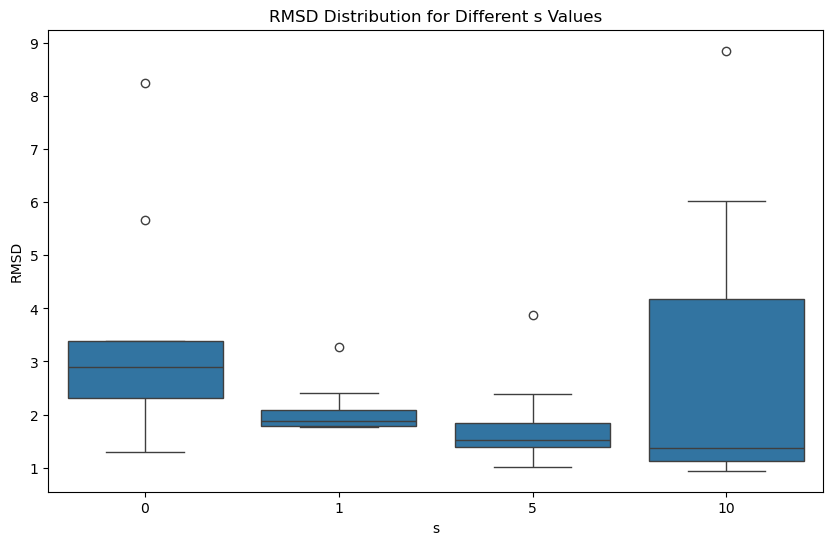

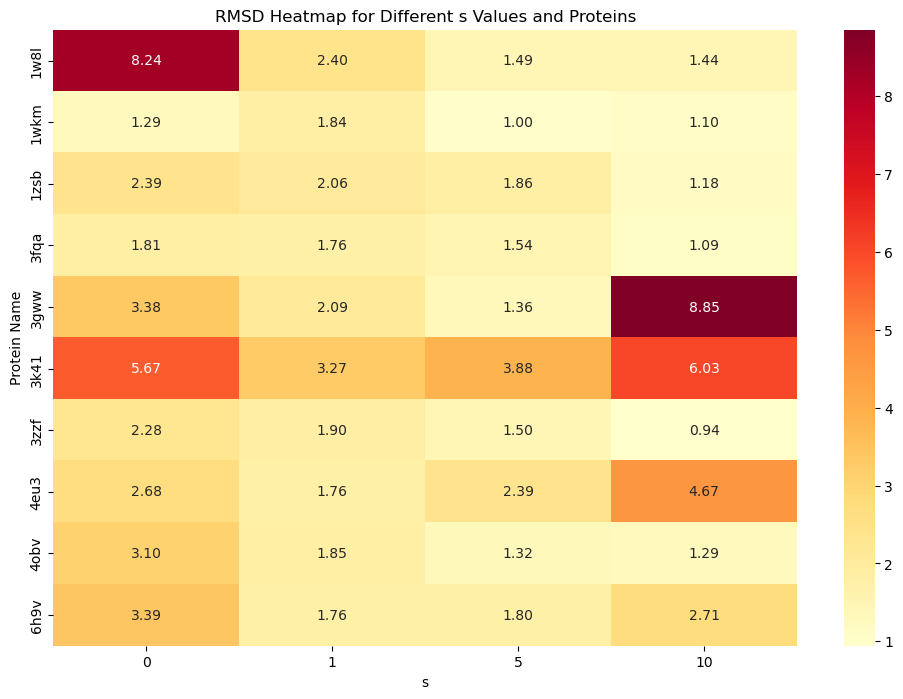


Detailed Results:

s = 0:
1wkm: 1.29
3fqa: 1.81
3zzf: 2.28
1zsb: 2.39
4eu3: 2.68
4obv: 3.10
3gww: 3.38
6h9v: 3.39
3k41: 5.67
1w8l: 8.24

s = 1:
3fqa: 1.76
4eu3: 1.76
6h9v: 1.76
1wkm: 1.84
4obv: 1.85
3zzf: 1.90
1zsb: 2.06
3gww: 2.09
1w8l: 2.40
3k41: 3.27

s = 5:
1wkm: 1.00
4obv: 1.32
3gww: 1.36
1w8l: 1.49
3zzf: 1.50
3fqa: 1.54
6h9v: 1.80
1zsb: 1.86
4eu3: 2.39
3k41: 3.88

s = 10:
3zzf: 0.94
3fqa: 1.09
1wkm: 1.10
1zsb: 1.18
4obv: 1.29
1w8l: 1.44
6h9v: 2.71
4eu3: 4.67
3k41: 6.03
3gww: 8.85


In [80]:
import torch
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_test(s_values, test_protein_names, all_dict_coords, random_noise=1, num_initializations=1, num_iterations=100):
    results = []
    
    for s in s_values:
        print(f"Running test for s={s}")
        for protein_name in tqdm(test_protein_names, desc=f"s={s}"):
            protein_coords = all_dict_coords[protein_name]["protein"]
            ligand_coords = all_dict_coords[protein_name]["compound"]
            true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
            noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * random_noise
            ligand_pairwise_distances = torch.cdist(ligand_coords, ligand_coords)
            
            result = optimize_ligand_position(protein_coords=protein_coords,
                                    pairwise_distances_lig=ligand_pairwise_distances,
                                    noised_pairwise_distances=noised_pairwise_distances,
                                    s=s,
                                    num_initializations=num_initializations,
                                    num_iterations=num_iterations,
                                    device="cpu")
            
            rmsd = torch.norm(result - ligand_coords).item()
            results.append({"s": s, "protein_name": protein_name, "rmsd": rmsd})
    
    return pd.DataFrame(results)

# Run the test
list_protein_names = list(all_dict_coords.keys())
test_protein_names = list_protein_names[:10]
s_values = [0, 1, 5, 10]

results_df = run_test(s_values, test_protein_names, all_dict_coords)

# Display summary statistics
summary = results_df.groupby('s')['rmsd'].agg(['mean', 'std', 'min', 'max'])
print("Summary Statistics:")
print(summary)

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='s', y='rmsd', data=results_df)
plt.title('RMSD Distribution for Different s Values')
plt.xlabel('s')
plt.ylabel('RMSD')
plt.show()

# Create a heatmap
pivot_df = results_df.pivot(index='protein_name', columns='s', values='rmsd')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('RMSD Heatmap for Different s Values and Proteins')
plt.xlabel('s')
plt.ylabel('Protein Name')
plt.show()

# Display detailed results
print("\nDetailed Results:")
for s in s_values:
    print(f"\ns = {s}:")
    s_results = results_df[results_df['s'] == s].sort_values('rmsd')
    for _, row in s_results.iterrows():
        print(f"{row['protein_name']}: {row['rmsd']:.2f}")

Running test for s=0


s=0:   0%|          | 0/10 [00:00<?, ?it/s]

Summary Statistics:
      mean       std           min       max
s                                           
0  0.71025  2.246007  3.040071e-14  7.102499


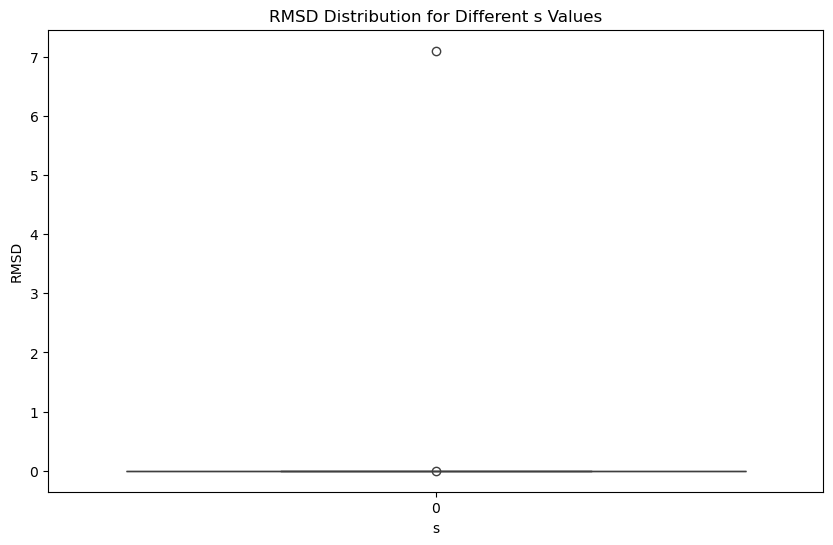

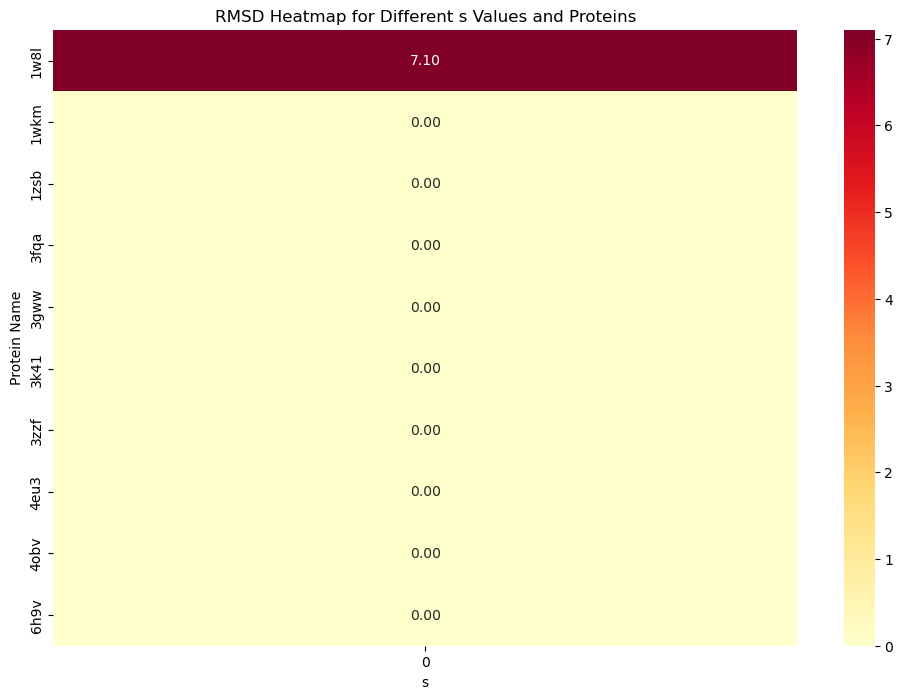


Detailed Results:

s = 0:
1zsb: 0.00
3fqa: 0.00
6h9v: 0.00
3zzf: 0.00
4eu3: 0.00
3gww: 0.00
3k41: 0.00
1wkm: 0.00
4obv: 0.00
1w8l: 7.10


In [83]:
import torch
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_test(s_values, test_protein_names, all_dict_coords, random_noise=0, num_initializations=1, num_iterations=100):
    results = []
    
    for s in s_values:
        print(f"Running test for s={s}")
        for protein_name in tqdm(test_protein_names, desc=f"s={s}"):
            protein_coords = all_dict_coords[protein_name]["protein"]
            ligand_coords = all_dict_coords[protein_name]["compound"]
            true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
            noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * random_noise
            ligand_pairwise_distances = torch.cdist(ligand_coords, ligand_coords)
            
            result = optimize_ligand_position(protein_coords=protein_coords,
                                    pairwise_distances_lig=ligand_pairwise_distances,
                                    noised_pairwise_distances=noised_pairwise_distances,
                                    s=s,
                                    num_initializations=num_initializations,
                                    num_iterations=num_iterations,
                                    device="cuda:1")
            
            rmsd = torch.norm(result - ligand_coords).item()
            results.append({"s": s, "protein_name": protein_name, "rmsd": rmsd})
    
    return pd.DataFrame(results)

# Run the test
list_protein_names = list(all_dict_coords.keys())
test_protein_names = list_protein_names[:10]
s_values = [0,]

results_df = run_test(s_values, test_protein_names, all_dict_coords, num_initializations=10, num_iterations=1000)

# Display summary statistics
summary = results_df.groupby('s')['rmsd'].agg(['mean', 'std', 'min', 'max'])
print("Summary Statistics:")
print(summary)

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='s', y='rmsd', data=results_df)
plt.title('RMSD Distribution for Different s Values')
plt.xlabel('s')
plt.ylabel('RMSD')
plt.show()

# Create a heatmap
pivot_df = results_df.pivot(index='protein_name', columns='s', values='rmsd')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('RMSD Heatmap for Different s Values and Proteins')
plt.xlabel('s')
plt.ylabel('Protein Name')
plt.show()

# Display detailed results
print("\nDetailed Results:")
for s in s_values:
    print(f"\ns = {s}:")
    s_results = results_df[results_df['s'] == s].sort_values('rmsd')
    for _, row in s_results.iterrows():
        print(f"{row['protein_name']}: {row['rmsd']:.2f}")

Running test for s=0


s=0:   0%|          | 0/10 [00:00<?, ?it/s]

Running test for s=1


s=1:   0%|          | 0/10 [00:00<?, ?it/s]

Running test for s=5


s=5:   0%|          | 0/10 [00:00<?, ?it/s]

Running test for s=10


s=10:   0%|          | 0/10 [00:00<?, ?it/s]

Summary Statistics:
        mean       std       min       max
s                                         
0   2.958938  0.828846  1.796077  4.353689
1   2.228013  0.793022  1.548438  4.029681
5   1.931639  0.564578  1.310018  3.328982
10  1.563792  0.454338  1.122668  2.605015


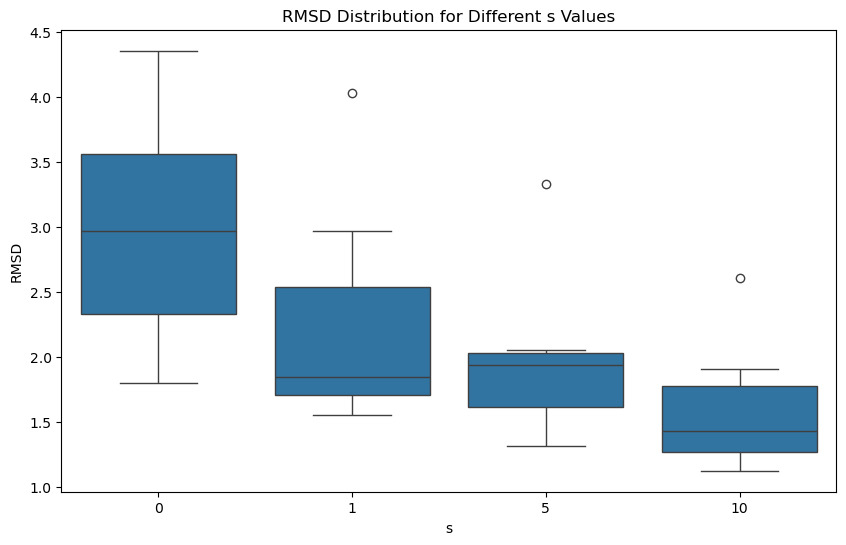

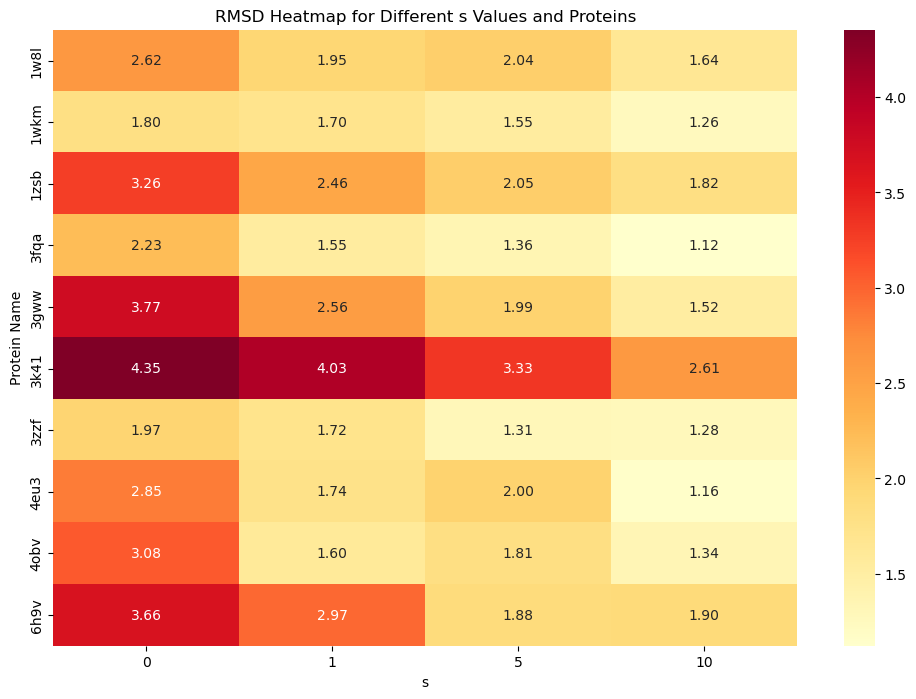


Detailed Results:

s = 0:
1wkm: 1.80
3zzf: 1.97
3fqa: 2.23
1w8l: 2.62
4eu3: 2.85
4obv: 3.08
1zsb: 3.26
6h9v: 3.66
3gww: 3.77
3k41: 4.35

s = 1:
3fqa: 1.55
4obv: 1.60
1wkm: 1.70
3zzf: 1.72
4eu3: 1.74
1w8l: 1.95
1zsb: 2.46
3gww: 2.56
6h9v: 2.97
3k41: 4.03

s = 5:
3zzf: 1.31
3fqa: 1.36
1wkm: 1.55
4obv: 1.81
6h9v: 1.88
3gww: 1.99
4eu3: 2.00
1w8l: 2.04
1zsb: 2.05
3k41: 3.33

s = 10:
3fqa: 1.12
4eu3: 1.16
1wkm: 1.26
3zzf: 1.28
4obv: 1.34
3gww: 1.52
1w8l: 1.64
1zsb: 1.82
6h9v: 1.90
3k41: 2.61


In [82]:
import torch
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_test(s_values, test_protein_names, all_dict_coords, random_noise=1, num_initializations=1, num_iterations=100):
    results = []
    
    for s in s_values:
        print(f"Running test for s={s}")
        for protein_name in tqdm(test_protein_names, desc=f"s={s}"):
            protein_coords = all_dict_coords[protein_name]["protein"]
            ligand_coords = all_dict_coords[protein_name]["compound"]
            true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
            noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * random_noise
            ligand_pairwise_distances = torch.cdist(ligand_coords, ligand_coords)
            
            result = optimize_ligand_position(protein_coords=protein_coords,
                                    pairwise_distances_lig=ligand_pairwise_distances,
                                    noised_pairwise_distances=noised_pairwise_distances,
                                    s=s,
                                    num_initializations=num_initializations,
                                    num_iterations=num_iterations,
                                    device="cuda:1")
            
            rmsd = torch.norm(result - ligand_coords).item()
            results.append({"s": s, "protein_name": protein_name, "rmsd": rmsd})
    
    return pd.DataFrame(results)

# Run the test
list_protein_names = list(all_dict_coords.keys())
test_protein_names = list_protein_names[:10]
s_values = [0, 1, 5, 10]

results_df = run_test(s_values, test_protein_names, all_dict_coords, num_initializations=10, num_iterations=1000)

# Display summary statistics
summary = results_df.groupby('s')['rmsd'].agg(['mean', 'std', 'min', 'max'])
print("Summary Statistics:")
print(summary)

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='s', y='rmsd', data=results_df)
plt.title('RMSD Distribution for Different s Values')
plt.xlabel('s')
plt.ylabel('RMSD')
plt.show()

# Create a heatmap
pivot_df = results_df.pivot(index='protein_name', columns='s', values='rmsd')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('RMSD Heatmap for Different s Values and Proteins')
plt.xlabel('s')
plt.ylabel('Protein Name')
plt.show()

# Display detailed results
print("\nDetailed Results:")
for s in s_values:
    print(f"\ns = {s}:")
    s_results = results_df[results_df['s'] == s].sort_values('rmsd')
    for _, row in s_results.iterrows():
        print(f"{row['protein_name']}: {row['rmsd']:.2f}")

In [ ]:
import torch
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_test(s_values, test_protein_names, all_dict_coords, random_noise=1, num_initializations=10, num_iterations=100):
    results = []
    
    for s in s_values:
        print(f"Running test for s={s}")
        for protein_name in tqdm(test_protein_names, desc=f"s={s}"):
            protein_coords = all_dict_coords[protein_name]["protein"]
            ligand_coords = all_dict_coords[protein_name]["compound"]
            true_pairwise_distances = torch.cdist(protein_coords, ligand_coords)
            noised_pairwise_distances = true_pairwise_distances + torch.randn_like(true_pairwise_distances) * random_noise
            ligand_pairwise_distances = torch.cdist(ligand_coords, ligand_coords)
            
            result = optimize_ligand_position(protein_coords=protein_coords,
                                    pairwise_distances_lig=ligand_pairwise_distances,
                                    noised_pairwise_distances=noised_pairwise_distances,
                                    s=s,
                                    num_initializations=num_initializations,
                                    num_iterations=num_iterations,
                                    device="cuda:1")
            
            rmsd = torch.norm(result - ligand_coords).item()
            results.append({"s": s, "protein_name": protein_name, "rmsd": rmsd})
    
    return pd.DataFrame(results)

# Run the test
list_protein_names = list(all_dict_coords.keys())
test_protein_names = list_protein_names[:100]
s_values = [0, 1, 5, 10]

results_df = run_test(s_values, test_protein_names, all_dict_coords, num_initializations=10, num_iterations=1000)

# Display summary statistics
summary = results_df.groupby('s')['rmsd'].agg(['mean', 'std', 'min', 'max'])
print("Summary Statistics:")
print(summary)

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='s', y='rmsd', data=results_df)
plt.title('RMSD Distribution for Different s Values')
plt.xlabel('s')
plt.ylabel('RMSD')
plt.show()

# Create a heatmap
pivot_df = results_df.pivot(index='protein_name', columns='s', values='rmsd')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('RMSD Heatmap for Different s Values and Proteins')
plt.xlabel('s')
plt.ylabel('Protein Name')
plt.show()

# Display detailed results
print("\nDetailed Results:")
for s in s_values:
    print(f"\ns = {s}:")
    s_results = results_df[results_df['s'] == s].sort_values('rmsd')
    for _, row in s_results.iterrows():
        print(f"{row['protein_name']}: {row['rmsd']:.2f}")